# Code

Below there is the code of the algorithm, together with plotting to test the algorithms.

Nothing else than numpy, matplotlib and pygsp are required.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from random import sample
from math import sqrt
import random

## Parameters

Change here the seed for reproductibility.   
Also you can modify $N$, $S$, $M$, $L$ with the same meaning as the article.  
$\epsilon$ is tolerance for comparison with $0$.

Small values of the parameters ($N=4,S=3,M=12$) are suggested in order to visualize the graphics.  
On very small values errors arise randomly.

In [2]:
plotting.BACKEND = 'matplotlib'
seed = random.randint(0,10*1000*1000) # I know. Let's not talk about it
random.seed(seed)
np.random.seed(seed + 1)
N = 16
S = 5
c = 8
M = c*N*S
L = int((1. + sqrt(N)) / 2.)
epsilon = 0

## Dictionary class

The aim of this class is to store a dictionary of atoms, and update them efficiently.

In [3]:
def half_normal(mu, sigma, shape):
    return np.absolute(np.random.normal(0., 1., shape))

In [4]:
class Dictionary:
    def __init__(self, g, s):
        self.n = g.N
        self.s = s
        self.k = self.n * self.s
        g.compute_fourier_basis()
        self.U = g.U
        #np.array([[1.5],[0.5],[0.4],[0.2]])#
        self.lbda = half_normal(0., 1., (self.n,self.s))
        self._compute_D()
        
    def normalize(self):
        norm = np.linalg.norm(self.D, axis=0)
        self.D = self.D / norm
        return norm
    
    def rescale(self, norm):
        self.D = self.D * norm
        
    def _compute_D(self):
        subdicts = []
        for col in range(self.s):
            lbda = np.diag(self.lbda[:,col])
            subdict = self.U @ lbda @ self.U.T
            subdicts.append(subdict)
        self.D = np.concatenate(subdicts, axis=1)
        
    def update_lbda(self, lbda, k):
        self.lbda[:,k] = lbda
        subdict = self.U @ np.diag(lbda) @ self.U.T
        self.D[:,self.n*k : self.n*(k+1)] = subdict
        
    def get_subdict(self, k):
        return self.D[:,self.n*k : self.n*(k+1)]
    
    def get_lbda(self, k):
        return self.lbda[:,k]
    
    def get_atom(self, i):
        return self.D[:,i]

## The sensor graph

Together with the corresponding dictionary that will be used to generate signals.  
The $\lambda$ is also visible.

In [5]:
g = graphs.Sensor(N, seed=seed)
D = Dictionary(g, S)

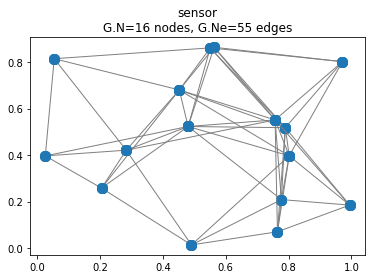

In [6]:
g.plot()

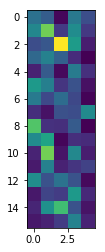

In [7]:
plt.imshow(D.lbda)

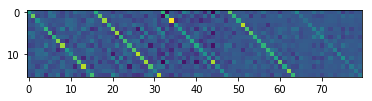

In [8]:
plt.imshow(D.D)

## Signals

The set of signals generated from the dictionary.

In [9]:
def generate_signal(D):
    indexes = sample(list(range(D.k)), L)
    x = half_normal(0., 1., L)
    y = sum([np.expand_dims(D.D[:,k],axis=1)*x[i] for i, k in enumerate(indexes)], np.zeros((D.n,1)))
    return y

In [10]:
def generate_signals(D):
    Y = np.concatenate([generate_signal(D) for i in range(M)], axis=1)
    return Y

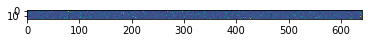

In [11]:
Y = generate_signals(D)
plt.imshow(Y)

## Dictionary updating step

In [12]:
def dictionary_update(Y, D, X):
    E = np.copy(Y)
    # Factorize the sum of error approximation matrix
    for k in range(D.s):
        D_k = D.get_subdict(k)
        X_k = X[k*D.n : (k+1)*D.n ,:]
        E = E - (D_k @ X_k)
    for k in range(D.s):
        D_k = D.get_subdict(k)
        X_k = X[k*D.n : (k+1)*D.n ,:]
        E_k = E + (D_k @ X_k) # current error approximation matrix
        b = np.diag(D.U.T @ X_k @ X_k.T @ D.U)
        a = np.diag(D.U.T @ X_k @ E_k.T @ D.U)
        lbda = D.get_lbda(k)
        for i in range(D.n):
            if abs(b[i]) <= epsilon:
                lbda[i] = max(0, a[i] / b[i])
        D.update_lbda(lbda, k)

## Orthogonal Matching pursuit

Tested with one iteration, with the dictionary $D$ that generated the signals $Y$. 

In [13]:
def orthogonal_matching_pursuit(D, y):
    R = np.copy(y)
    phi = None
    indexes = []
    for j in range(L):
        index = np.argmax(R @ D.D)
        indexes.append(index)
        atom = np.expand_dims(D.get_atom(index),axis=1)
        phi = atom if phi is None else np.concatenate([phi,atom],axis=1)
        psi = np.linalg.inv(phi.T @ phi) @ phi.T
        P = phi @ psi
        R = R - (P @ R)
    x = np.zeros((D.k,1))
    # complete missing values of x
    x[indexes] = np.expand_dims(psi.dot(y),axis=1)
    return x

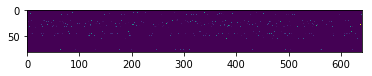

In [14]:
OMP = orthogonal_matching_pursuit
X = np.concatenate([OMP(D,Y[:,i]) for i in range(Y.shape[1])],axis=1)
plt.imshow(X)

## Putting everything together

In [15]:
def dictionary_learning(g, Y, max_iterations=100):
    D = Dictionary(g, S)
    OMP = orthogonal_matching_pursuit
    for _ in range(max_iterations):
        # 1.a normalize each atom
        #norm = D.normalize()
        # 1.b use OMP to compute x for each signal y under D
        X = np.concatenate([OMP(D,Y[:,i]) for i in range(Y.shape[1])],axis=1)
        # 1.c rescale atoms and coefficients to recover the structure
        #D.rescale(norm)
        #X = X / norm[:,np.newaxis]
        # 2. Update the dictionary
        dictionary_update(Y, D, X)
    return D, X

# Experiments

Comparion between the learned dictionary $D_r$ and the one of reference $D$.  
Comparison between the reconstructed signal $Y_r$ and the one of reference $Y$.  

## Learned dictionary

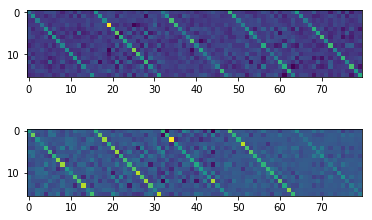

In [16]:
D_r, X_r = dictionary_learning(g, Y)
plt.subplot(211)
plt.imshow(D_r.D)
plt.subplot(212)
plt.imshow(D.D)

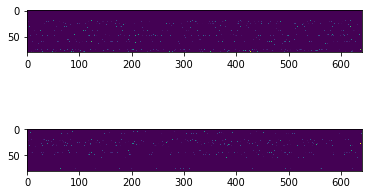

In [17]:
plt.subplot(211)
plt.imshow(X_r)
plt.subplot(212)
plt.imshow(X)

Using the criterion of the article we count the number of atoms recovered.

In [18]:
def match_dictionaries(D1, D2):
    nb_matchs = 0
    for i in range(D1.k):
        atom1 = D1.get_atom(i)
        atom1 = atom1 / np.linalg.norm(atom1)
        best_c = float("inf")
        for j in range(D2.k):
            atom2 = D2.get_atom(j)
            atom2 = atom2 / np.linalg.norm(atom2)
            c = np.dot(atom1, atom2)
            best_c = min(c, abs(1 - c))
        if best_c < 0.01:
                nb_matchs += 1
    return nb_matchs

nb_matchs = match_dictionaries(D, D_r)
score = (nb_matchs / D.k) * 100
print("Percentage of recovered atoms {}%".format(score))

Percentage of recovered atoms 57.49999999999999%


## Error over the reconstructed signal

The real point of interest of the algorithm.  
Both signals (original and reconstructed) are shown.  
Various statistics of the relative error matrix.  
Histogram of errors.

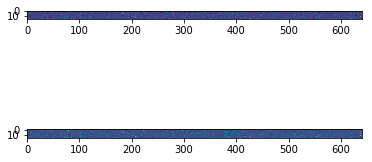

In [19]:
Y_r = D_r.D @ X_r
plt.subplot(211)
plt.imshow(Y_r)
plt.subplot(212)
plt.imshow(Y)

Worst error  1.4093637038233129
RMSE of E    0.1597248267088451
RMSE of the worst component of each signal   0.31794659523120744
RMSE of the components of the worst signal   0.5609852052542603


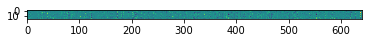

In [20]:
E = Y - Y_r
plt.imshow(E)
print("Worst error ", np.absolute(E).max())
print("RMSE of E   ", sqrt(np.mean(E ** 2))) 
print("RMSE of the worst component of each signal  ", sqrt(np.mean(E.max(axis=0)**2)))
print("RMSE of the components of the worst signal  ", np.sqrt((E ** 2).mean(axis=0)).max())

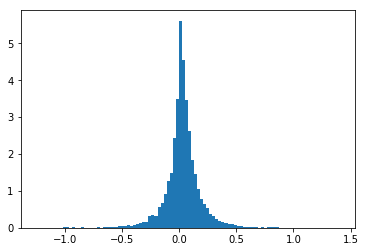

In [21]:
_ = plt.hist(E.flatten(),bins=100,normed=True,stacked=True)